# Correlation analysis

This notebook performs correlation analysis to compare the similarity between genes and applies different threshold cutoffs to determine the strength of connection between genes

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
from scipy.spatial.distance import pdist, squareform
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

For now we will vary the correlation threshold (`corr_threshold`) but keep the other parameters consistent

We will run this notebook for each threshold parameter

In [2]:
# Params
corr_threshold = 0.5

# Output files
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(847, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541579,150.908951,63.968306,56.863002,86.013480,32.240954,48.322611,21.099413,21.219456,31.521424,12.168960,...,0.000000,16.606783,38.218939,8.611779,28.396413,110.943698,137.583940,101.058282,65.210599,0.000000
ERX541580,108.323515,56.079007,57.001674,73.421480,18.426169,46.572630,16.606703,18.595344,30.253393,15.936006,...,0.000000,13.904292,37.246074,11.777708,45.733000,94.799523,53.486191,82.753701,23.340646,38.113576
ERX541591,556.704228,182.309588,81.730476,157.348561,85.185006,116.643999,36.964524,31.973493,63.109930,16.140763,...,14.312595,73.032021,80.369628,49.312460,69.099677,61.622295,103.911157,186.030844,478.965167,0.000000
ERX541592,428.470250,178.510235,74.953217,152.142022,92.393069,95.317522,33.668009,31.262234,81.131515,20.126563,...,6.691671,114.618032,62.583672,56.426453,58.473904,55.311934,101.620394,207.409539,345.057960,0.000000
ERX676205,555.932721,530.701952,295.028891,336.887163,160.855884,196.799841,24.062303,127.448405,251.543954,29.933785,...,9.935461,59.660341,268.159400,40.929204,30.272774,284.146647,357.806954,260.651493,110.621722,0.000000


In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(520, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,11.030217,1.370300,0.683438,63.527772,34.586977,4.709054,5.274344,8.137393,5.310585,0.766974,...,10.688588,82.981151,63.650349,28.877599,7.956130,56.829502,269.183334,6.074311,29.079407,100.748813
ERX1477380,13.419626,3.039174,1.334504,105.003820,70.493150,8.849012,6.802855,18.784232,11.978251,2.088495,...,15.823345,91.090917,62.400165,24.819442,3.132517,31.325168,181.774134,10.866863,16.090103,233.317754
ERX1477381,13.155391,5.684725,7.208220,143.201487,107.849795,12.753058,8.868100,27.482294,13.951196,1.251785,...,28.406181,98.909427,71.429549,24.114657,6.515803,18.616579,184.357151,13.112427,13.970424,93.182566
ERX2174773,4.201447,4.194614,3.283683,3.273384,20.188057,3.804287,2.665245,2.650568,20.062716,3.755125,...,41.954387,35.821193,114.727681,104.737209,0.000000,391.722223,160.215744,18.980486,20.985404,182.605858
ERX2174774,5.016892,3.306859,3.446703,2.676762,17.199329,3.748607,1.618736,4.083091,21.225030,2.373772,...,44.138587,26.599121,105.848301,104.402335,0.000000,444.485136,168.538985,24.906987,19.775702,206.865218


## Visualize distribution of raw data

Text(0.5, 1.05, 'Random set of genes')

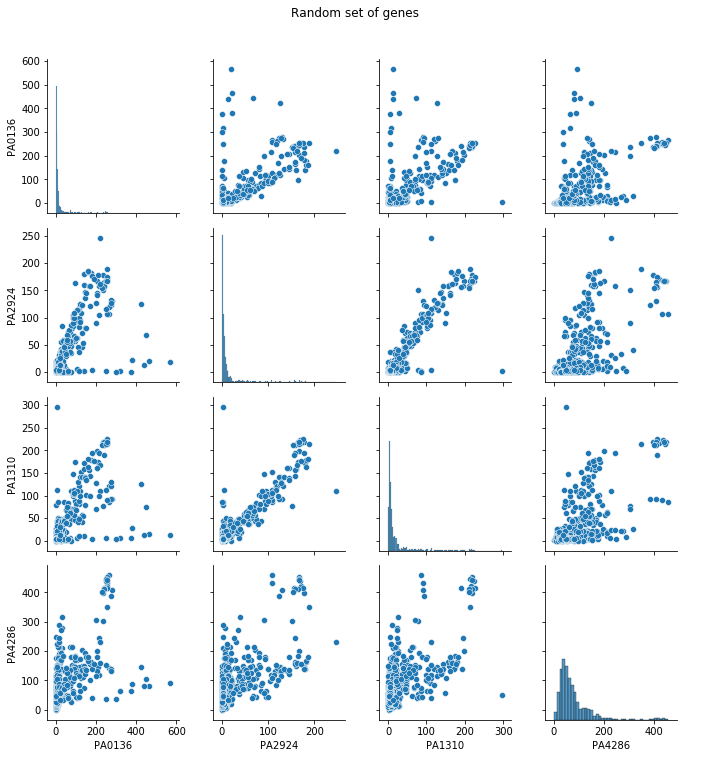

In [7]:
# Random PAO1 genes
random_pao1_ids = random.sample(list(pao1_compendium.columns), 4)
sns.pairplot(pao1_compendium[random_pao1_ids])
plt.suptitle("Random set of genes", y=1.05)

Text(0.5, 1.05, 'Co-operonic set of genes')

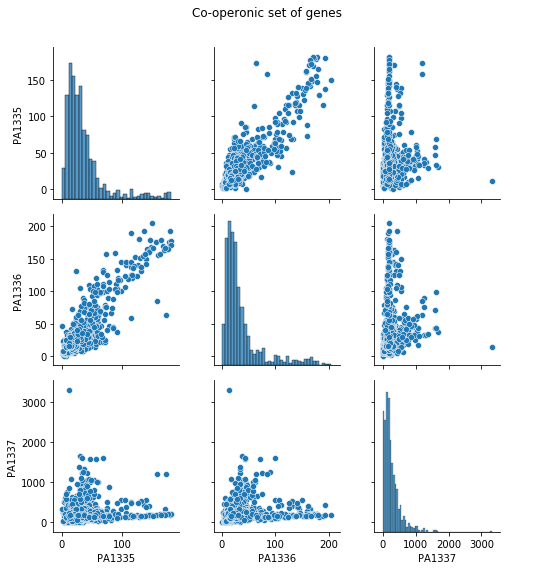

In [8]:
# Co-operonic PAO1 genes
# pao1_co_operonic_ids = ["PA0001", "PA0002", "PA0003", "PA0004"]
# pao1_co_operonic_ids = ["PA0054","PA0055", "PA0056"]
pao1_co_operonic_ids = ["PA1335", "PA1336", "PA1337"]
sns.pairplot(pao1_compendium[pao1_co_operonic_ids])
plt.suptitle("Co-operonic set of genes", y=1.05)

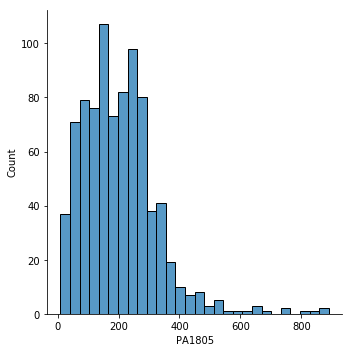

In [9]:
# Houskeeping PAO1 gene that we would expect a consistently high expression across samples
# which doesn't have that peak at 0
sns.displot(pao1_compendium["PA1805"])

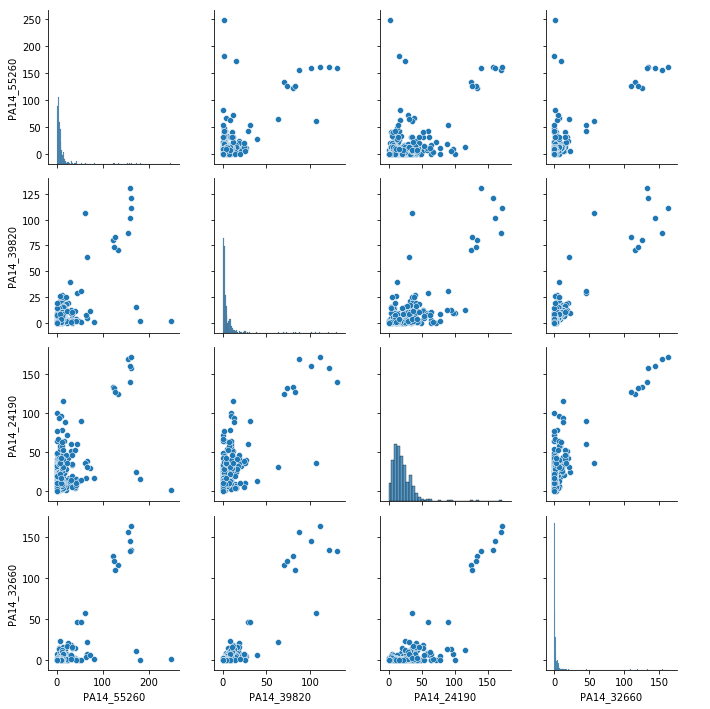

In [10]:
# Random PA14 gene
random_pa14_ids = random.sample(list(pa14_compendium.columns), 4)
sns.pairplot(pa14_compendium[random_pa14_ids])

## Get similarity between genes

To determine if genes are similar, we will calculate the correlation between genes and apply our threshold cutoff. When we apply our threshold, any scores that are below the threshold will be set to 0 (i.e. using a threshold of 0.5 means that gene pairs that have correlation scores of 0.52 and 0.78 will be left as is but a gene pair with a correlation score of 0.48 will be set to 0).

In [11]:
# Get perason correlation
# This correlation matrix will represent the concordance
# between two gene expression profiles
pao1_corr = pao1_compendium.corr()
pa14_corr = pa14_compendium.corr()

In [12]:
pao1_corr.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.594557,0.687148,0.505865,0.377674,0.261739,-0.299738,0.474802,0.603762,0.174995,...,-0.253705,-0.028448,-0.044004,0.052642,0.148591,0.357547,0.091949,0.564941,0.062275,-0.110323
PA0002,0.594557,1.000000,0.378676,0.755231,0.231155,0.006332,-0.216134,0.539810,0.449625,0.114658,...,-0.130466,-0.121234,0.091491,0.047837,-0.001691,0.537656,0.258719,0.383020,-0.097028,0.019944
PA0003,0.687148,0.378676,1.000000,0.516913,0.318357,0.320915,-0.296210,0.338235,0.541252,0.166932,...,-0.251259,-0.168138,0.115740,-0.087703,0.189975,0.362242,0.215174,0.453543,0.178327,-0.187517
PA0004,0.505865,0.755231,0.516913,1.000000,0.241149,0.116621,-0.303192,0.634115,0.466545,0.170033,...,-0.218643,-0.195855,0.173532,-0.130051,0.082266,0.569530,0.276853,0.359069,-0.086630,-0.081832
PA0005,0.377674,0.231155,0.318357,0.241149,1.000000,0.655372,0.029865,0.598108,0.553519,0.589714,...,0.005931,0.146424,0.148445,0.330324,0.183055,0.248982,-0.066924,0.511783,0.453148,-0.091535


In [13]:
# Create a similarity matrix usingn the threshold defined above
# The similarity matrix will determine the strength of the connection between two genes
# If the concordance is strong enough (i.e. above the threshold), then
# the genes are connected by by the correlation score, otherwise the value is set to 0
pao1_corr[pao1_corr.abs() < corr_threshold] = 0.0
pa14_corr[pa14_corr.abs() < corr_threshold] = 0.0

pao1_corr.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
PA0001,1.000000,0.594557,0.687148,0.505865,0.0,0.000000,0.0,0.000000,0.603762,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.564941,0.0,0.0
PA0002,0.594557,1.000000,0.000000,0.755231,0.0,0.000000,0.0,0.539810,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.537656,0.0,0.000000,0.0,0.0
PA0003,0.687148,0.000000,1.000000,0.516913,0.0,0.000000,0.0,0.000000,0.541252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
PA0004,0.505865,0.755231,0.516913,1.000000,0.0,0.000000,0.0,0.634115,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.569530,0.0,0.000000,0.0,0.0
PA0005,0.000000,0.000000,0.000000,0.000000,1.0,0.655372,0.0,0.598108,0.553519,0.589714,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.511783,0.0,0.0


In [14]:
pa14_corr.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
PA14_55610,1.000000,0.706899,0.673723,0.000000,0.000000,0.000000,0.00000,0.000000,0.530105,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA14_55600,0.706899,1.000000,0.689163,0.000000,0.000000,0.000000,0.00000,0.000000,0.570891,0.0,...,0.511247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA14_55590,0.673723,0.689163,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.514414,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA14_55580,0.000000,0.000000,0.000000,1.000000,0.535382,0.649706,0.56024,0.569508,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PA14_55570,0.000000,0.000000,0.000000,0.535382,1.000000,0.000000,0.00000,0.545702,0.525853,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plot distribution of pairwise distances

This will particularly help to inform the parameters we use for DBSCAN, which is density based

Text(0.5, 1.0, 'Distribution of pairwise distances for PAO1 genes')

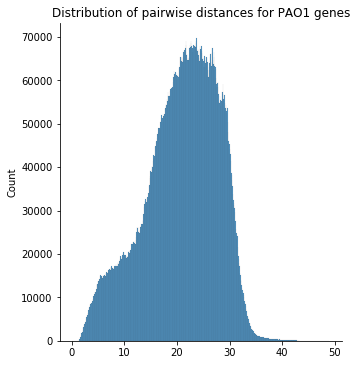

In [15]:
# Get distribution of pairwise distances to determine a cutoff defining what a dense region should be
f1 = sns.displot(pdist(pao1_corr))
plt.title("Distribution of pairwise distances for PAO1 genes")

Text(0.5, 1.0, 'Distribution of pairwise distances for PA14 genes')

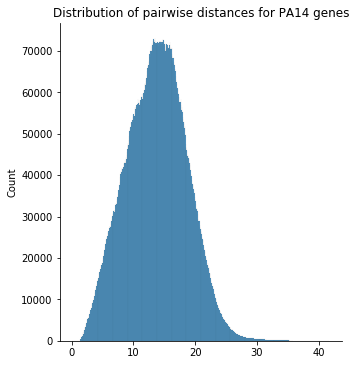

In [16]:
f2 = sns.displot(pdist(pa14_corr))
plt.title("Distribution of pairwise distances for PA14 genes")

## Plot correlation

We will plot a heatmap and umap of the correlations to identify clusters, which should help to inform the parameters for hierarchal clustering - i.e. how many clusters can we expect?

<Figure size 1440x1440 with 0 Axes>

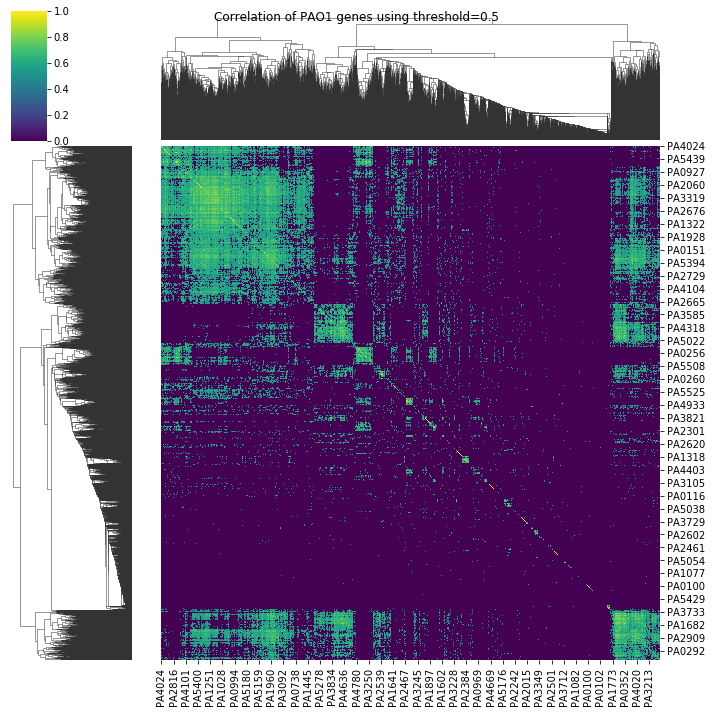

In [17]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr.abs(), cmap="viridis")
h1.fig.suptitle(f"Correlation of PAO1 genes using threshold={corr_threshold}")

# Save
pao1_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_corr_{corr_threshold}_clustermap.png"
)
h1.savefig(pao1_clustermap_filename, dpi=300)

<Figure size 1440x1440 with 0 Axes>

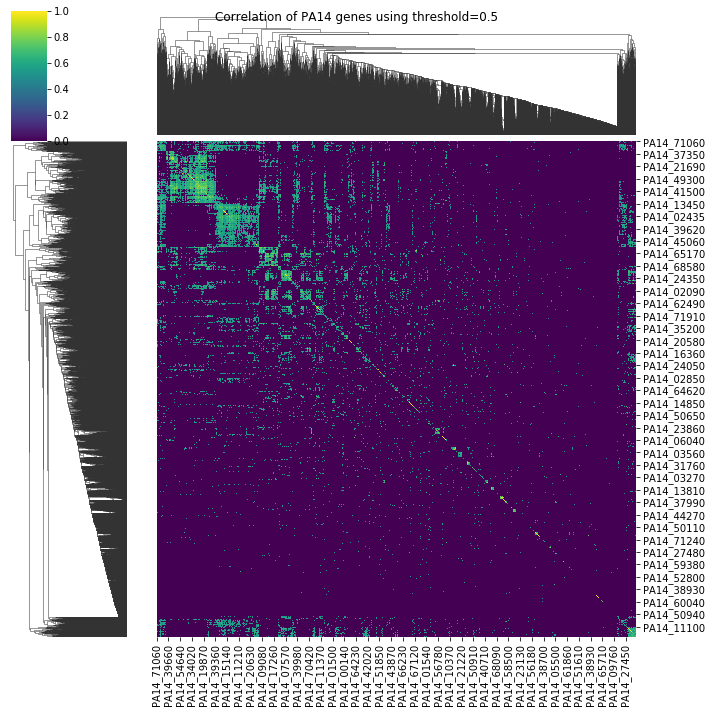

In [18]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr.abs(), cmap="viridis")
h2.fig.suptitle(f"Correlation of PA14 genes using threshold={corr_threshold}")

# Save
pa14_clustermap_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_corr_{corr_threshold}_clustermap.png"
)
h2.savefig(pa14_clustermap_filename, dpi=300)

In [23]:
# Save
pao1_corr_filename = f"pao1_corr_{corr_threshold}.tsv"
pa14_corr_filename = f"pa14_corr_{corr_threshold}.tsv"
pao1_corr.to_csv(os.path.join(paths.LOCAL_DATA_DIR, pao1_corr_filename), sep="\t")
pa14_corr.to_csv(os.path.join(paths.LOCAL_DATA_DIR, pa14_corr_filename), sep="\t")

**Takeaway:**

Here we are visualizing the clustering of raw correlation scores where values < `corr_threshold` are set to 0. If we compare the clustermap results in this notebook with [1a_get_network_communities_complex.ipynb](1a_get_network_communities_complex.ipynb) where we cluster the on the Topological Overlap Matrix (TOM) we see:
* Clustering pattern between using raw correlation score vs TOM is similar. TOM is considering secondary relationships (i.e. gene _i_ and _j_ are similar if they are linked in the adjacency matrix and gene _i_ is connected to all the neighbors of gene _j_)
* At thresholds 0.5, 0.6 there seems to be 1 large cluster, some very smaller clusters, then all other genes that are below the threshold
* As we increase the threshold to 0.8 and 0.9, this very large cluster is broken up into more equal sized smaller clusters
* In terms of distance, for threshold of 0.5, 0.6 high density regions look like those > 20. For thresholds 0.7-0.9, high density regions look like those > 15.

Overall, clustering may make sense using higher thresholds (0.8, 0.9) and excluding the community containing the remaining genes. However then we are not left with many genes, so perhaps it makes sense to consider a different similarity/correlation metric to use?
* Looking at the pair plots of the raw expression data (estimated counts - an estimate of the number of reads drawn from this transcript given the transcript’s relative abundance and length). There is a tendency for genes to have a long right tail where some genes have a spike at 0 and some do not. In this case Spearman correlation might be more appropriate here.

After meeting with Casey, the main takeaway is that:
* It appears that the TOM matrix is not as sensitive since its setting nearby genes to have a score of 1.
Using just the correlation score is grouping genes into one large cluster.
* To dappen the overwhelming signal of highly correlated genes we will look into applying these two methods:
https://pubmed.ncbi.nlm.nih.gov/17724061/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768301/